# Prepare

## Clone the repo

In [1]:
%cd /content
!rm -rf arabic-poetry-speech-classification
!git clone https://github.com/MagedSaeed/arabic-poetry-speech-classification.git
%cd arabic-poetry-speech-classification

/content
Cloning into 'arabic-poetry-speech-classification'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (49/49), done.
remote: Compressing objects: 100% (37/37), done.
remote: Total 49 (delta 21), reused 30 (delta 11), pack-reused 0
Unpacking objects: 100% (49/49), done.
/content/arabic-poetry-speech-classification


## Install Requirements

In [2]:
%%capture
!pip install -r requirements.txt

In [3]:
%%capture
!pip install torchaudio
!pip install transformers
!pip install datasets
!pip install lang_trans
!pip install arabic_reshaper
!pip install python-bidi
!pip install pydub
!pip install tnkeeh
!pip install soundfile
!pip install jiwer==2.2.0
!pip install PyArabic

## Imports

In [4]:
import os
import torch
import torchaudio
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from pyarabic import araby
from datasets import Dataset
from pydub import AudioSegment
from audio_utils import get_audio
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor,Wav2Vec2PreTrainedModel,Wav2Vec2FeatureExtractor,Wav2Vec2Model

## Helper Classes and methods

In [5]:
class CustomWav2Vec2Processor:
    def __init__(self, feature_extractor):
        self.feature_extractor = feature_extractor
        self.current_processor = self.feature_extractor

    def save_pretrained(self, save_directory):
        self.feature_extractor.save_pretrained(save_directory)

    @classmethod
    def from_pretrained(cls, pretrained_model_name_or_path, **kwargs):
        feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(
            pretrained_model_name_or_path, **kwargs
        )
        return cls(feature_extractor=feature_extractor)

    def __call__(self, *args, **kwargs):
        return self.current_processor(*args, **kwargs)

    def pad(self, *args, **kwargs):
        return self.current_processor.pad(*args, **kwargs)

In [6]:
class Wav2Vec2ClassificationModel(Wav2Vec2PreTrainedModel):
    def __init__(self, config):
        super().__init__(config)

        self.wav2vec2 = Wav2Vec2Model(config)

        self.inner_dim = 128
        self.feature_size = 999

        self.tanh = nn.Tanh()
        self.linear1 = nn.Linear(1024, self.inner_dim)
        self.linear2 = nn.Linear(self.inner_dim * self.feature_size, 16)
        self.init_weights()

    def freeze_feature_extractor(self):
        self.wav2vec2.feature_extractor._freeze_parameters()

    def forward(
        self,
        input_values,
        attention_mask=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
        labels=None,
    ):
        return_dict = (
            return_dict if return_dict is not None else self.config.use_return_dict
        )

        outputs = self.wav2vec2(
            input_values,
            attention_mask=attention_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        x = self.linear1(outputs[0])
        x = self.tanh(x)
        x = self.linear2(x.view(-1, self.inner_dim * self.feature_size))
        return {"logits": x}

In [7]:
char2idx = {
    " ": 1,
    "#": 2,
    "ء": 3,
    "آ": 4,
    "أ": 5,
    "ؤ": 6,
    "إ": 7,
    "ئ": 8,
    "ا": 9,
    "ب": 10,
    "ة": 11,
    "ت": 12,
    "ث": 13,
    "ج": 14,
    "ح": 15,
    "خ": 16,
    "د": 17,
    "ذ": 18,
    "ر": 19,
    "ز": 20,
    "س": 21,
    "ش": 22,
    "ص": 23,
    "ض": 24,
    "ط": 25,
    "ظ": 26,
    "ع": 27,
    "غ": 28,
    "ف": 29,
    "ق": 30,
    "ك": 31,
    "ل": 32,
    "م": 33,
    "ن": 34,
    "ه": 35,
    "و": 36,
    "ى": 37,
    "ي": 38,
}
meters_mapping = {
    0: 4,
    1: 6,
    2: 8,
    3: 7,
    4: 13,
    5: 10,
    6: 9,
    7: 3,
    8: 0,
    9: 1,
    10: 5,
    11: 15,
    12: 14,
    13: 2,
}
meter_class_to_label = {v:k for k,v in {
    "البسيط": 0,
    "الخفيف": 1,
    "الرجز": 2,
    "الرمل": 3,
    "السريع": 4,
    "الطويل": 5,
    "الكامل": 6,
    "المتدارك": 7,
    "المتقارب": 8,
    "المجتث": 9,
    "المديد": 10,
    "المضارع": 11,
    "المقتضب": 12,
    "المنسرح": 13,
    "الهزج": 14,
    "الوافر": 15,
}.items()}

meter_label_to_class = {
    "البسيط": 0,
    "الخفيف": 1,
    "الرجز": 2,
    "الرمل": 3,
    "السريع": 4,
    "الطويل": 5,
    "الكامل": 6,
    "المتدارك": 7,
    "المتقارب": 8,
    "المجتث": 9,
    "المديد": 10,
    "المضارع": 11,
    "المقتضب": 12,
    "المنسرح": 13,
    "الهزج": 14,
    "الوافر": 15,
}

In [8]:
meter_label_to_class.keys()

dict_keys(['البسيط', 'الخفيف', 'الرجز', 'الرمل', 'السريع', 'الطويل', 'الكامل', 'المتدارك', 'المتقارب', 'المجتث', 'المديد', 'المضارع', 'المقتضب', 'المنسرح', 'الهزج', 'الوافر'])

In [9]:
resamplers = {  # all three sampling rates exist in test split
    48000: torchaudio.transforms.Resample(48000, 16000),
    44100: torchaudio.transforms.Resample(44100, 16000),
    32000: torchaudio.transforms.Resample(32000, 16000),
}


def get_resampled_speech(file_path):
    original_speech, sampling_rate = torchaudio.load(file_path)
    if sampling_rate in resamplers:
        speech = resamplers[sampling_rate](original_speech[0]).squeeze().numpy()
    else:
        speech = resamplers[48000](original_speech[0]).squeeze().numpy()
    return speech

def put_hash_after_middle_word(sentence):
    middle_char = len(sentence) // 2
    closest_space_index = middle_char
    while True:
        try:
            if sentence[closest_space_index] == " ":
                break
            else:
                closest_space_index += 1
        except:
            closest_space_index = len(sentence) - 1
            break
    sentence = sentence[:closest_space_index] + " #" + sentence[closest_space_index:]
    return sentence

In [10]:
class Transcriber:
    def __init__(self, model_path, processor_path="bakrianoo/sinai-voice-ar-stt"):
        self.processor = Wav2Vec2Processor.from_pretrained(processor_path)
        self.model = Wav2Vec2ForCTC.from_pretrained(model_path).eval()
        self.model.to("cuda")

    def transcribe(self, file_path):
        speech = get_resampled_speech(file_path)
        inputs = self.processor(
            speech, sampling_rate=16000, return_tensors="pt", padding=True
        )
        with torch.no_grad():
            predicted = torch.argmax(self.model(inputs.input_values.to('cuda')).logits, dim=-1)
        predicted[predicted == -100] = self.processor.tokenizer.pad_token_id
        predicted_tokenized = self.processor.tokenizer.batch_decode(predicted)
        return predicted_tokenized

In [11]:
class SignalClassifier:
    def __init__(self, model_path):
        self.feature_extractor = Wav2Vec2FeatureExtractor(
            feature_size=1,
            sampling_rate=16_000,
            padding_value=0.0,
            do_normalize=True,
            return_attention_mask=True,
        )
        self.processor = CustomWav2Vec2Processor(feature_extractor=self.feature_extractor)
        self.model = Wav2Vec2ClassificationModel.from_pretrained(model_path).eval()
        self.model.to('cuda')

    def classify(self, file_path):
        speech = get_resampled_speech(file_path)
        features = self.processor(
            speech,
            max_length=320000,
            sampling_rate=16000,
            pad_to_multiple_of=320000,
            padding=True,
            return_tensors="pt",
        )
        attention_mask = features.attention_mask.to("cuda")
        with torch.no_grad():
            predicted = torch.argmax(
                self.model(
                    features.input_values.to("cuda"), attention_mask=attention_mask
                )["logits"],
                dim=-1,
            )
        meter_class = predicted.tolist()[0]
        return meter_class
        # return meter_class_to_label[meter_class]

In [12]:
class TextClassifier:
    def __init__(self, transcriber, model_path='/content/drive/MyDrive/KFUPM-Master/ICS606/Models/arabic_poetry_text_classification_model.h5'):
        self.model = tf.keras.models.load_model(model_path)
        self.transcriber = transcriber

    def classify(self, file_path):
        predicted_text = self.transcriber.transcribe(file_path)[0]
        predicted_text = araby.strip_tashkeel(predicted_text)
        predicted_text = put_hash_after_middle_word(predicted_text)
        sequence = [char2idx[char] for char in predicted_text if char2idx.get(char)]
        sequence = pad_sequences([sequence], maxlen=100, padding="post", value=0)
        predictions = self.model.predict(sequence)[0]
        label = meters_mapping[np.argmax(predictions, 0).astype("int")]
        return meter_class_to_label[label]

# Model Paths

In [13]:
transcribtion_original_model = "bakrianoo/sinai-voice-ar-stt"
transcribition_finetuned_model = '/content/drive/MyDrive/KFUPM-Master/ICS606/Models/SinaiFineTuned/checkpoint-1600'
signal_classification_original_model = '/content/drive/MyDrive/KFUPM-Master/ICS606/Models/ClassificationModelSinai/checkpoint-7000'
signal_classification_original_model_no_shuffled_dataset = '/content/drive/MyDrive/KFUPM-Master/ICS606/Models/NoShuffledDatasetOverfitting'
signal_classification_finetuned_model = '/content/drive/MyDrive/KFUPM-Master/ICS606/Models/ClassificationModelSinaiFineTuned/checkpoint-6500'
text_to_meter_label_classifier = '/content/drive/MyDrive/KFUPM-Master/ICS606/Models/arabic_poetry_text_classification_model.h5'

In [14]:
!cp -r /content/drive/MyDrive/KFUPM-Master/ICS606/Dataset/All_poems.zip .

In [15]:
if os.path.exists('dataset'):
  if len(os.listdir('dataset')) == 0:
    os.system('unzip All_poems.zip -d dataset')
else:
  os.system('unzip All_poems.zip -d dataset')

In [16]:
!mkdir -p dataset_wav

In [17]:
metadata_test_path = '/content/drive/MyDrive/KFUPM-Master/ICS606/Dataset/test_metadata.xlsx'
# metadata_test_path = '/content/drive/MyDrive/KFUPM-Master/ICS606/Dataset/testset.csv'
dataset_folder = 'dataset'
dataset_wav_folder = 'dataset_wav'

In [19]:
# metadata = pd.read_excel(metadata_test_path)
metadata = pd.read_excel(metadata_test_path)
metadata

,No.,Utterance name,Script,Bahr,Source,Name when extacted,Original name in document,Further info on Bahr,Name of document
0,89,P-89.aac,إنَّ بالشِّعبِ الَّذي دُونَ سَلْعٍ لَقتيل...,المديد,ديوان ثابت بن جابرص35,89.aac,89.aac,NaN,NaN
1,90,P-90.aac,خَلَّفَ الْعِبْءَ عَلَيَّ وَولَّى أنا بال...,المديد,ديوان ثابت بن جابرص35,90.aac,90.aac,NaN,NaN
2,91,P-91.aac,ووراءَ الثَّأر منِّي ابنُ أختٍ مَصِعٌ عُق...,المديد,ديوان ثابت بن جابرص35,91.aac,91.aac,NaN,NaN
3,92,P-92.aac,مُطْرِقٌ يَرْشَحُ سَمًّا كَمَا أَطْ رَقَ ...,المديد,ديوان ثابت بن جابرص35,92.aac,92.aac,NaN,NaN
4,93,P-93.aac,خبرٌ ما نابَنا مُصْمَئِلٌّ جلَّ حتّى دقَّ...,المديد,ديوان ثابت بن جابرص35,93.aac,93.aac,NaN,NaN
...,...,...,...,...,...,...,...,...,...
354,3682,P-3682.m4a,حِسانُ الوُجوهِ حِدادُ السُيو فِ يَبتَدِر...,المتقارب,ديوان قيس بن الخطيم ص 73,ÇáÊÓÌíá (98).m4a,التسجيل (98).m4a,NaN,NaN
355,3683,P-3683.m4a,وَبِالشَوطِ مِن يَثرِبٍ أَعبُدٌ سَتَهلِكُ...,المتقارب,ديوان قيس بن الخطيم ص 73,ÇáÊÓÌíá (99).m4a,التسجيل (99).m4a,NaN,NaN
356,3684,P-3684.m4a,يَهونُ عَلى الأَوسِ أَثمانُهُم إِذا راحَ ...,المتقارب,ديوان قيس بن الخطيم ص 73,ÇáÊÓÌíá (100).m4a,التسجيل (100).m4a,NaN,NaN
357,3685,P-3685.m4a,أَتَتهُم عَرانينُ مِن مالِكٍ سِراعٌ إِلى ...,المتقارب,ديوان قيس بن الخطيم ص 73,ÇáÊÓÌíá (101).m4a,التسجيل (101).m4a,NaN,NaN


In [20]:
sample_rates = set()
for file_path in tqdm(list(metadata['Utterance name'])):
  complete_path = f'{dataset_folder}/{file_path}'
  complete_wav_path = f'{dataset_wav_folder}/{file_path}'
  # os.system(f'ffmpeg -i {complete_path} {complete_wav_path}')
  audio = AudioSegment.from_file(complete_path)
  sample_rates.add(audio.frame_rate)
  audio.export(f'{dataset_wav_folder}/{file_path}', format='wav')
sample_rates

100%|██████████| 359/359 [01:13<00:00,  4.89it/s]


{44100, 48000}

In [21]:
dataset = Dataset.from_pandas(metadata)
dataset

Dataset({
    features: ['No.', 'Utterance name', 'Script', 'Bahr', 'Source', ' Name when extacted', 'Original name in document', 'Further info on Bahr', 'Name of document'],
    num_rows: 359
})

In [22]:
resamplers = {  # The dataset contains all the uncommented sample rates
    48000: torchaudio.transforms.Resample(48000, 16000),
    44100: torchaudio.transforms.Resample(44100, 16000),
    # 32000: torchaudio.transforms.Resample(32000, 16000),
}

In [23]:
classifier = SignalClassifier(model_path=signal_classification_original_model_no_shuffled_dataset)

In [24]:
def predict(example):
  example['predicted'] = classifier.classify(f'{dataset_wav_folder}/{example["Utterance name"]}')
  return example

In [25]:
dataset = dataset.map(predict)

  0%|          | 0/359 [00:00<?, ?ex/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/wav2vec2/modeling_wav2vec2.py:1055: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  return (input_length - kernel_size) // stride + 1


In [26]:
def compute_metrics(preds,labels):
    print(labels)
    print(preds)
    acc = accuracy_score(labels, preds)
    report = classification_report(labels, preds)
    matrix = confusion_matrix(labels, preds)
    print(matrix)
    print('clasification report',report)
    print('accuracy',acc)

In [27]:
compute_metrics(preds=[example['predicted'] for example in dataset],labels=[meter_label_to_class[example['Bahr']] for example in dataset])

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 2, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 15, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 1, 1, 1, 1, 1, 1, 1, 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [28]:
meter_class_to_label[15]

'الوافر'

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


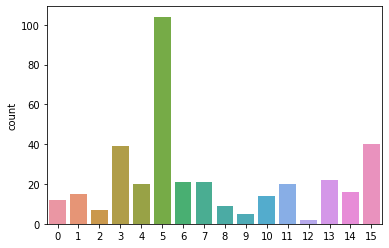

In [ ]:
sns.countplot([example['predicted'] for example in dataset])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


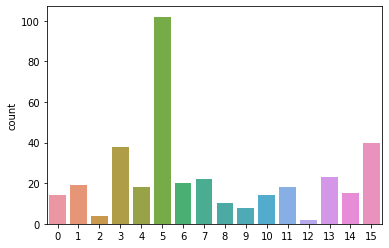

In [ ]:
sns.countplot([meter_label_to_class[example['Bahr']] for example in dataset])

In [ ]:
meter_class_to_label[15]

'الوافر'